In [1]:
import torch
import faces_model
from PIL import Image
import data_utils as data
import torchvision.transforms as transforms
from torch.autograd import Variable
from net_sphere import sphere20a
from open_face_model import OpenFace
import matplotlib.pyplot as plt

import torchvision

import torch.nn as nn

from datasets import celebA
from data_utils import *

In [2]:
class ZeroPadBottom(object):
    ''' Zero pads batch of image tensor Variables on bottom to given size. Input (B, C, H, W) - padded on H axis. '''
    def __init__(self, size, use_gpu=True):
        self.size = size
        self.use_gpu = use_gpu
        
    def __call__(self, sample):
        B, C, H, W = sample.size()
        diff = self.size - H
        padding = Variable(torch.zeros(B, C, diff, W), requires_grad=False)
        if self.use_gpu:
            padding = padding.cuda()
        zero_padded = torch.cat((sample, padding), dim=2)
        return zero_padded

In [4]:
model = torch.load('final_models/emoji/fin_model_emoji.tar', map_location='cpu')

train_loss


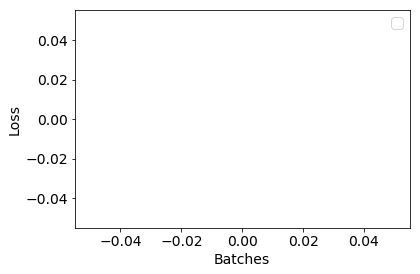

lconst_src_loss


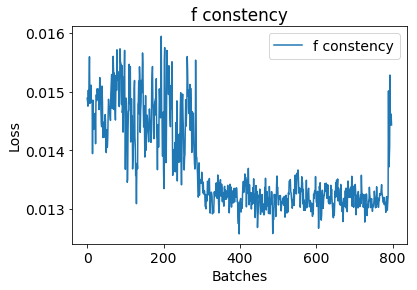

d_train_trg_loss


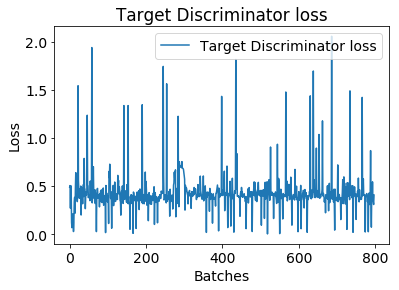

G_model
D_model
d_train_src_loss


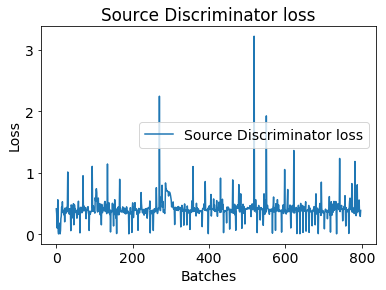

g_train_src_loss


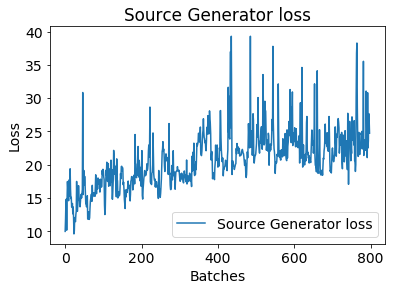

g_train_trg_loss


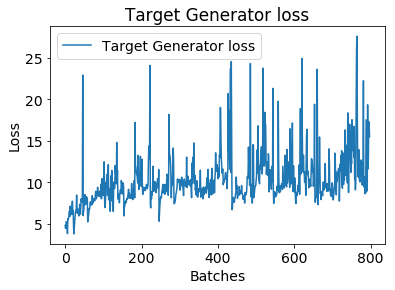

best_model
val_loss


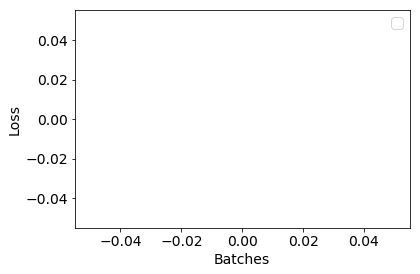

In [7]:

import matplotlib
plt.figure()
matplotlib.rcParams['font.size'] = 14
titles_pair = {
'lconst_src_loss' : "f constency",
'd_train_trg_loss' : "Target Discriminator loss",
'd_train_src_loss' : "Source Discriminator loss",
'g_train_src_loss' : "Source Generator loss",
'g_train_trg_loss' : "Target Generator loss",
    'train_loss':'',
    'val_loss':'',
    
} 

for key in model:
    print(key)
    if 'loss' in key and model[key] is not None:
        y = model[key][2:]
        x = np.arange(0, 11450, 50)
        plt.plot(y,label=titles_pair[key])
        plt.legend()
        plt.ylabel('Loss')
        plt.xlabel('Batches')
        plt.title(titles_pair[key])
        plt.savefig('results/plots/emoji/'+key)
        plt.show()
        plt.close()


# import matplotlib
# plt.figure()
# matplotlib.rcParams['font.size'] = 14
# for key in model:
#     if 'loss' in key and model[key] is not None:
#         y = model[key][2:]
#         x = np.arange(0, 11450, 50)
#         plt.plot(y,label=key)
#         plt.legend()
# #         plt.ylabel('Loss')
# #         plt.xlabel('Batches (size 128)')
#         plt.show()

In [39]:
from predict_all import *

In [40]:
img = Image.open('./predictset/emoji/000001.jpg')

In [41]:
image = predict_emoji(img) 

predict emoji
(torch.Size([1, 128]), torch.Size([1, 736]))


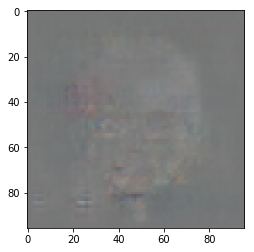

In [42]:
plt.imshow(image)

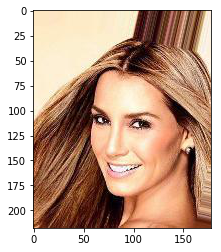

In [14]:
plt.imshow(img)

#### Porting models to cpu 

In [7]:
from net_sphere import sphere20a
from open_face_model import OpenFace

In [8]:
cartoon_f_model = sphere20a(feature=True)
cartoon_f_model.load_state_dict(torch.load('./pretrained_model/sphere20a_20171020.pth'))
for param in cartoon_f_model.parameters():
	param.requires_grad = False
cartoon_f_model = cartoon_f_model.cuda()
cartoon_model = torch.load('./final_models/cartoonset/fin_model_cartoon.tar')

open_f_model = OpenFace(True, 0)
open_f_model.load_state_dict(torch.load('./pretrained_model/openface.pth'))
open_f_model = open_f_model.eval()
simpson_model = torch.load('./final_models/simpsons/fin_model_simpson.tar')
emoji_model = torch.load('./final_models/emoji/fin_model_emoji.tar')

In [9]:
openf_cpu = open_f_model.cpu()
torch.save(openf_cpu.state_dict(), 'models/openf_cpu.pt')

In [13]:
emoji_g_cpu = emoji_model['G_model'].cpu()
torch.save(emoji_g_cpu.state_dict(), 'models/emoji_g_cpu.pt')

In [17]:
simpson_g_cpu = simpson_model['G_model'].cpu()
torch.save(simpson_g_cpu.state_dict(), 'models/simpson_g_cpu.pt')

In [18]:
cartoon_g_cpu = cartoon_model['G_model'].cpu()
torch.save(cartoon_g_cpu.state_dict(), 'models/cartoon_g_cpu.pt')

In [19]:
spheref_cpu = cartoon_f_model.cpu()
torch.save(spheref_cpu.state_dict(), 'models/spheref_cpu.pt')

In [11]:
toPIL = transforms.ToPILImage()
toTensor = transforms.ToTensor()
pad112 = ZeroPadBottom(112)
predict_transform = transforms.Compose(
                [data.ResizeTransform(96), data.NormalizeRangeTanh()])
unnorm_emoji = UnNormalizeRangeTanh()
up96 = nn.Upsample(size=(96,96), mode='bilinear')


In [33]:
open_f_model = OpenFace(False, 0)
open_f_model.load_state_dict(torch.load('./models/openf_cpu.pt'))
open_f_model = open_f_model.eval()

In [34]:
model_g = faces_model.G(in_channels=864)
model_g.load_state_dict(torch.load('./models/emoji_g_cpu.pt'))

In [35]:
image = img
image = predict_transform(image)

image = image.unsqueeze(0)

img_v = Variable(image.float(), requires_grad=False)
f, f_736 = open_f_model(img_v)
print(f.size(), f_736.size())
s_G = model_g(torch.cat((f, f_736), dim=1))

s_G = up96(s_G)
s_G = s_G.data
res = unnorm_emoji(s_G[:16])
npimg = torchvision.utils.make_grid(res, nrow=4).numpy()
npimg = np.transpose(npimg, (1, 2, 0))
zero_array = np.zeros(npimg.shape)
one_array = np.ones(npimg.shape)
npimg = np.minimum(npimg,one_array)
npimg = np.maximum(npimg,zero_array)

(torch.Size([1, 128]), torch.Size([1, 736]))


/anaconda2/envs/cs7643/lib/python2.7/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/anaconda2/envs/cs7643/lib/python2.7/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


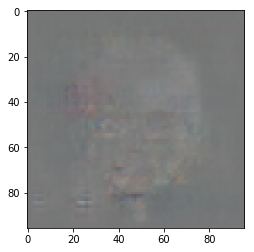

In [36]:
plt.imshow(npimg)

In [30]:
type(model_g)

faces_model.G